# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [180]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

# DSND colors: UBlue, Salmon, Gold, Slate
plot_colors = ['#02b3e4', '#ee2e76', '#ffb613', '#2e3d49']

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [181]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [182]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('AZDIAS: ', azdias.shape)
print('FEAT_INFO: ', feat_info.shape)

AZDIAS:  (891221, 85)
FEAT_INFO:  (85, 4)


In [183]:
print('##### GENERAL POPULATION #####')
print(azdias.iloc[:10,:])
print()
print(azdias.info())

##### GENERAL POPULATION #####
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   
5         3                     1          2            2.0   
6        -1                     2          2            5.0   
7        -1                     1          1            3.0   
8        -1                     3          1            3.0   
9        -1                     3          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1   

In [184]:
print('\n##### FEATURES INFO #####')
#print(feat_info.iloc[:])
print(feat_info.info())
print(feat_info.iloc[:])


##### FEATURES INFO #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB
None
                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordin

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [185]:
# Identify missing or unknown data values and convert them to NaNs.
# Check null values in demographics data

for index in feat_info.index:
    feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]')
    feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].split(',')
    
    for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
        try:
            feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
        except:
            continue
            
    azdias.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)

In [186]:
print(azdias[:10])

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   
5       3.0                   1.0          2            2.0   
6       NaN                   2.0          2            5.0   
7       NaN                   1.0          1            3.0   
8       NaN                   3.0          1            3.0   
9       NaN                   3.0          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3             

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [187]:
# % missingData per col
missingDataCol = azdias.isnull().sum(axis=0) 
missingDataCol.sort_values(ascending=False, inplace=True)
missingDataCol

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

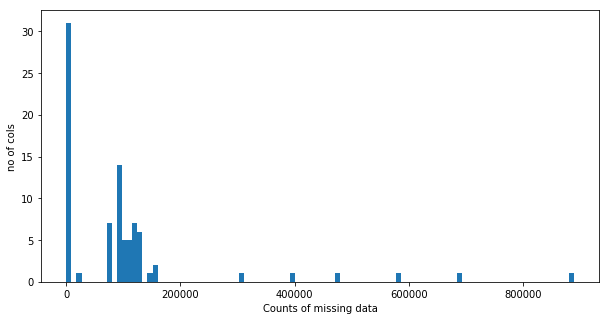

In [188]:
plt.figure(figsize=(10,5))
plt.hist(missingDataCol.values, bins=100)
plt.xlabel('Counts of missing data')
plt.ylabel('no of cols')
plt.show()

In [189]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Identify cols with > 200000 missing data
dropCols = list(missingDataCol[azdias.isnull().sum()>200000].index)
print(dropCols)

#azdias.drop(drop_cols, axis='columns', inplace=True)
azdiasDropOutliers = azdias.drop(dropCols, axis=1)
azdiasDropOutliers.shape

['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


(891221, 79)

In [190]:
def extract_cols_nan(df):
    
    # Extract cols with nans
    print(len(df))
    colNAN = df.isnull().sum()[df.isnull().sum() > 0]
    print(len(colNAN))
    
    # % nan for ea col (df.shape[0] == no of rows)
    dictNAN = {'sum': colNAN.values, 'percent': np.round(colNAN.values * 100 / df.shape[0], 2)}
    
    # New df with cols containing nan & sort
    dfColNAN = pd.DataFrame(data=dictNAN, index=colNAN.index)
    dfColNAN.sort_values(by='percent', ascending=False, inplace=True)
    
    return dfColNAN

In [191]:
azdiasColNAN = extract_cols_nan(azdiasDropOutliers)
azdiasColNAN

891221
55


,sum,percent
REGIOTYP,158064,17.74
KKK,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG1,133324,14.96
MOBI_REGIO,133324,14.96
KBA05_GBZ,133324,14.96
KBA05_ANTG2,133324,14.96
KBA05_ANTG3,133324,14.96
KBA05_ANTG4,133324,14.96
PLZ8_GBZ,116515,13.07


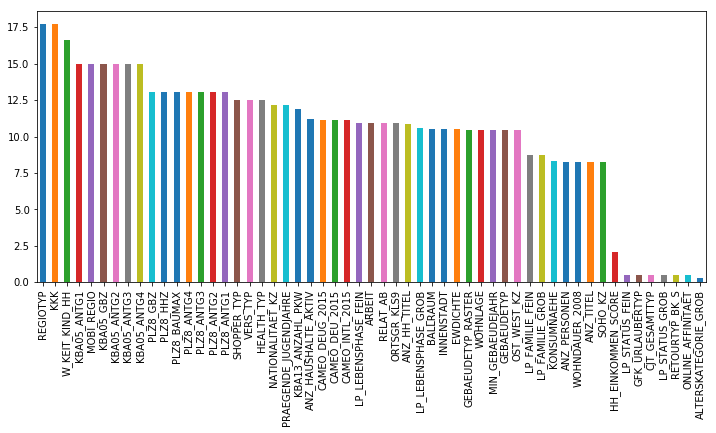

In [192]:
# Cols with nans barchart
'''
plt.figure(figsize=(12,5))
plt.bar(azdias_nan.index, azdias_cols_nan['percent'])
plt.xlabel('col names')
plt.ylabel('% nan')
plt.show()
'''
azdiasColNAN.percent.plot.bar(figsize=(12, 5))

In [193]:
# After dropping outlier columns, there're 7 columns with lowest nan
colLowestNAN = azdiasColNAN[azdiasColNAN['percent'] < 2]
print(colLowestNAN)
print('Cols with lowest nan counts: ', len(colLowestNAN))

                       sum  percent
LP_STATUS_FEIN        4854     0.54
GFK_URLAUBERTYP       4854     0.54
CJT_GESAMTTYP         4854     0.54
LP_STATUS_GROB        4854     0.54
RETOURTYP_BK_S        4854     0.54
ONLINE_AFFINITAET     4854     0.54
ALTERSKATEGORIE_GROB  2881     0.32
Cols with lowest nan counts:  7


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

There are 6 columns which have > 200000 missing data. These columns that were removed are ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']

After remove the 6 columns, there're 7 columns which has the lowest NaN counts (<1%):
                       sum  percent
LP_STATUS_FEIN        4854     0.54
GFK_URLAUBERTYP       4854     0.54
CJT_GESAMTTYP         4854     0.54
LP_STATUS_GROB        4854     0.54
RETOURTYP_BK_S        4854     0.54
ONLINE_AFFINITAET     4854     0.54
ALTERSKATEGORIE_GROB  2881     0.32

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [194]:
# How much data is missing in each row of the dataset?
'''
rows_nans = azdias.isnull().sum(axis=1)
percent_rows_nans = ((rows_nans/(azdias.shape[1]))*100).sort_values(ascending=False)
dict_rows_nans = {'sum': rows_nans.values,'percent':np.round(percent_rows_nans, 2)}
df_allrows_nans_percent = pd.DataFrame(data=dict_rows_nans, index=rows_nans.index)
'''

missingDataRow = azdias.isnull().sum(axis=1)
missingDataRowPercent = ((missingDataRow/(azdias.shape[1]))*100).sort_values(ascending=False)
missingDataRowDict = {'sum': missingDataRow.values,'percent':np.round(missingDataRowPercent, 2)}
df_missingDataAllRowPercent = pd.DataFrame(data=missingDataRowDict, index=missingDataRow.index)

In [195]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Split into rows with all data and rows with > 1 nan
df_completeDataRow = df_missingDataAllRowPercent[df_missingDataAllRowPercent['percent'] == 0.0]
df_rowsWithMissingData = df_missingDataAllRowPercent[df_missingDataAllRowPercent['percent'] > 0.0]
df_rowsMissingDataLess30 = df_missingDataAllRowPercent[df_missingDataAllRowPercent['percent'] < 30.0]
df_rowsMissingDataMore30 = df_missingDataAllRowPercent[df_missingDataAllRowPercent['percent'] > 30.1]

print('Total rows with no missing data: ', len(df_completeDataRow))
print('Total rows with > 1 NaN: ', len(df_rowsWithMissingData))
print('Total rows: ', len(df_completeDataRow) + len(df_rowsWithMissingData))
print('less30: ', len(df_rowsMissingDataLess30))

Total rows with no missing data:  143
Total rows with > 1 NaN:  891078
Total rows:  891221
less30:  797384


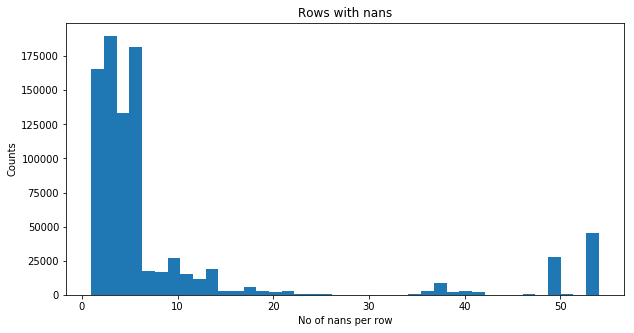

In [196]:
# Rows with nans
plt.figure(figsize=(10,5))
#plt.hist(df_rows_nans.values, bins=10)
plt.hist(df_rowsWithMissingData['sum'], bins=40)
#plt.hist(df_rows_nans['percent'], bins=40)
plt.xlabel('No of nans per row')
#plt.xlabel('% of nans per row')
plt.ylabel('Counts')
plt.title('Rows with nans')
plt.show()

In [197]:
def plot_countplot(df1, df2, colName):
    fig, ax =plt.subplots(1,2, figsize=(10,4))
    sns.countplot(df1[colName], ax=ax[0])
    sns.countplot(df2[colName], ax=ax[1])
    fig.show()

In [198]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

missingLess30 = azdias[azdias.isnull().sum(axis=1) < 30.0]
missingMore30 = azdias[azdias.isnull().sum(axis=1) > 30.0]

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


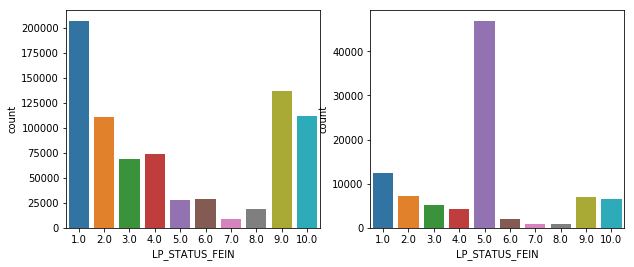

In [199]:
plot_countplot(missingLess30, missingMore30, 'LP_STATUS_FEIN')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


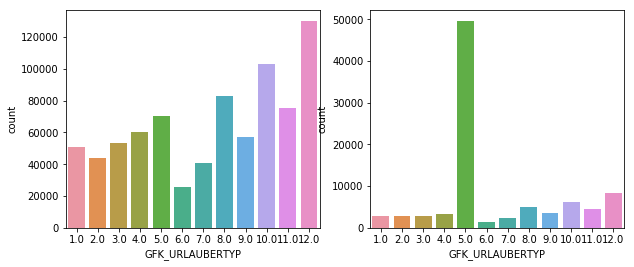

In [200]:
plot_countplot(missingLess30, missingMore30, 'GFK_URLAUBERTYP')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


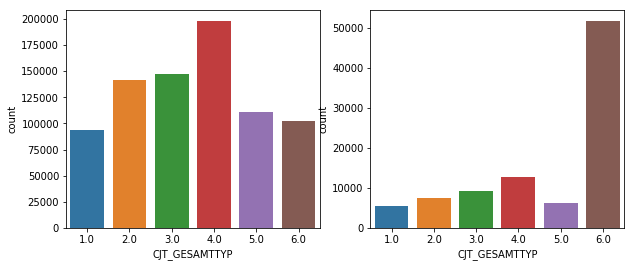

In [201]:
plot_countplot(missingLess30, missingMore30, 'CJT_GESAMTTYP')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


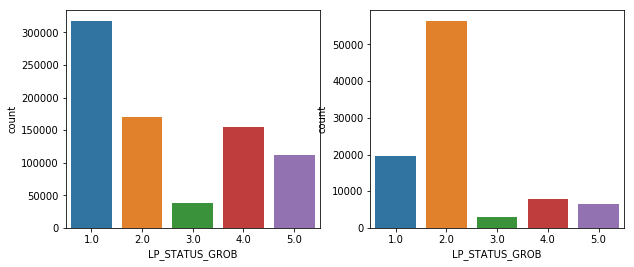

In [202]:
plot_countplot(missingLess30, missingMore30, 'LP_STATUS_GROB')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


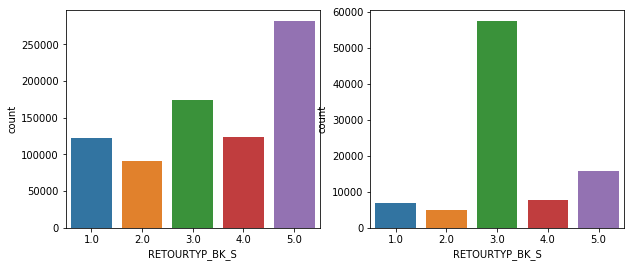

In [203]:
plot_countplot(missingLess30, missingMore30, 'RETOURTYP_BK_S')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


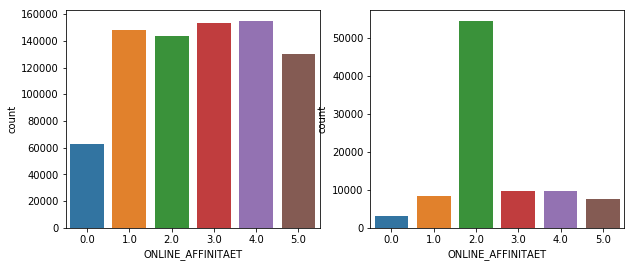

In [204]:
plot_countplot(missingLess30, missingMore30, 'ONLINE_AFFINITAET')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


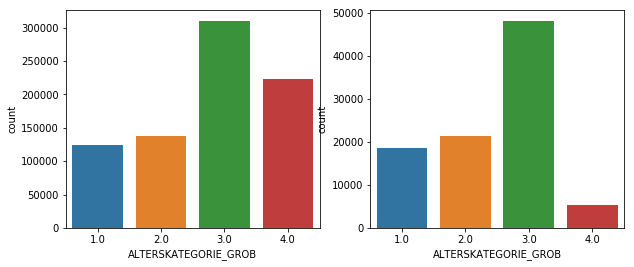

In [205]:
plot_countplot(missingLess30, missingMore30, 'ALTERSKATEGORIE_GROB')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

There are a total of 623209 rows with complete data and 268012 rows with more than 1 NaN. The dataset (with nans) seems to have 2 groups. One set of the group has data set that nans count between 1 - 9. The other group has 

Most of the data has nans count fall between > 1 to 9. Basically the dataset (with nans) seems to have 2 extreme groups, one group has missing 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [206]:
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [207]:
# How many features are there of each data type?
cat_var = feat_info[feat_info['type'] == 'categorical']
cat_list = feat_info[feat_info['type'] == 'categorical']['attribute'].values

mixed_var = feat_info[feat_info['type'] == 'mixed']
mixed_list = feat_info[feat_info['type'] == 'mixed']['attribute'].values

print('### Categorical type ###')
print()
print(cat_var)
print(cat_list)

print('\n### Mixed type ###')
print()
print(mixed_var)
print(mixed_list)

print('\n ### Lengths ###')
print('categorical type: ', len(cat_var))
print('mixed type: ', len(mixed_var))

### Categorical type ###

           attribute information_level         type missing_or_unknown
0           AGER_TYP            person  categorical            [-1, 0]
2          ANREDE_KZ            person  categorical            [-1, 0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical            [-1, 0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [208]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary = []
multi = []

for feat in cat_list:
    # If more than 2 unique vals, put int multi[]
    if azdias[feat].nunique() > 2:
        multi.append(feat)
    else:
        binary.append(feat)

In [209]:
print('### Binary ###')
print(binary)
print('\n### Multi ###')
print(multi)

### Binary ###
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

### Multi ###
['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [210]:
for col in binary:
    print(azdias[col].value_counts())
    print()

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64

0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64

0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64

2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64



In [211]:
azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)

In [212]:
for col in binary:
    print(azdias[col].value_counts())
    print()

1    465305
0    425916
Name: ANREDE_KZ, dtype: int64

0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64

0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64

1.0    398722
0.0    381303
Name: VERS_TYP, dtype: int64

1.0    629528
0.0    168545
Name: OST_WEST_KZ, dtype: int64



In [213]:
#azdias = pd.get_dummies(azdias, columns=categorical_multi)
#azdias_dummies = pd.get_dummies(azdias)
#azdias_dummies

In [214]:
azdias.shape

(891221, 85)

In [215]:
# Drop multi
for feat in multi:
    print(feat)
    azdias.drop(feat, axis=1, inplace=True)

AGER_TYP
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
TITEL_KZ
ZABEOTYP
KK_KUNDENTYP
GEBAEUDETYP
CAMEO_DEUG_2015
CAMEO_DEU_2015


In [216]:
azdias.shape

(891221, 69)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Keeping the binary categoricals as they can take numeric values. For binary categorical data 'OST_WEST_KZ' which has data of 2 characters, encoding them into '1' and '0' accordingly. For 'VERS_TYP' and 'ANREDE_KZ' which has original values of '2' and '1', converting them into '1' and '0' accordingly for consistency. 

Dropping all multi-level categoricals.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [217]:
# From above
print()
print(mixed_list)


['LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'PRAEGENDE_JUGENDJAHRE'
 'WOHNLAGE' 'CAMEO_INTL_2015' 'KBA05_BAUMAX' 'PLZ8_BAUMAX']


In [218]:
# Keep only 2 mixed and drop the rest
azdias.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
azdias.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
azdias.drop('WOHNLAGE', axis=1, inplace=True)
azdias.drop('KBA05_BAUMAX', axis=1, inplace=True)
azdias.drop('PLZ8_BAUMAX', axis=1, inplace=True)

In [219]:
#azdias[mixed_list]
azdias.shape

(891221, 64)

In [220]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['PRAEGENDE_JUGENDJAHRE']

0          NaN
1         14.0
2         15.0
3          8.0
4          8.0
5          3.0
6         10.0
7          8.0
8         11.0
9         15.0
10         3.0
11         NaN
12         8.0
13        15.0
14         NaN
15         5.0
16        14.0
17         NaN
18        10.0
19         9.0
20        11.0
21        10.0
22        14.0
23         9.0
24         NaN
25        14.0
26         8.0
27        11.0
28        10.0
29         6.0
          ... 
891191     3.0
891192    14.0
891193     5.0
891194    11.0
891195     8.0
891196    14.0
891197    11.0
891198    15.0
891199    10.0
891200    14.0
891201    10.0
891202    10.0
891203     NaN
891204    10.0
891205     3.0
891206    14.0
891207     2.0
891208     8.0
891209    14.0
891210     8.0
891211     8.0
891212     3.0
891213    11.0
891214    14.0
891215    10.0
891216    14.0
891217    10.0
891218    14.0
891219    14.0
891220     3.0
Name: PRAEGENDE_JUGENDJAHRE, Length: 891221, dtype: float64

In [221]:
### 1.18. PRAEGENDE_JUGENDJAHRE
'''
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
'''

"\nDominating movement of person's youth (avantgarde vs. mainstream; east vs. west)\n- -1: unknown\n-  0: unknown\n-  1: 40s - war years (Mainstream, E+W)\n-  2: 40s - reconstruction years (Avantgarde, E+W)\n-  3: 50s - economic miracle (Mainstream, E+W)\n-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)\n-  5: 60s - economic miracle (Mainstream, E+W)\n-  6: 60s - generation 68 / student protestors (Avantgarde, W)\n-  7: 60s - opponents to the building of the Wall (Avantgarde, E)\n-  8: 70s - family orientation (Mainstream, E+W)\n-  9: 70s - peace movement (Avantgarde, E+W)\n- 10: 80s - Generation Golf (Mainstream, W)\n- 11: 80s - ecological awareness (Avantgarde, W)\n- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)\n- 13: 80s - Swords into ploughshares (Avantgarde, E)\n- 14: 90s - digital media kids (Mainstream, E+W)\n- 15: 90s - ecological awareness (Avantgarde, E+W)\n"

In [222]:
### MOVEMENT ###
'''
# MAPPING category/label: 
# Find unique
moveList = ['Mainstream, E+W', 'Avantgarde, E+W', 'Mainstream, E+W', 'Avantgarde, E+W', 'Mainstream, E+W', \
            'Avantgarde, W', 'Avantgarde, E', 'Mainstream, E+W', 'Avantgarde, E+W', 'Mainstream, W', \
            'Avantgarde, W', 'Mainstream, E', 'Avantgarde, E', 'Mainstream, E+W', 'Avantgarde, E+W']
moveList = set(moveList)

mainstream: 0, 
avantgarde: 1
'''
moveDict= {1:0, 2:1, 3:0, 4:1, 5:0, \
           6:1, 7:1, 8:0, 9:1, 10:0, \
           11:1, 12:0, 13:1, 14:0, 15:1}


### DECADE ###
'''
# MAPPING category/label: 
[1,2] - 40s : 0
[3,4] - 50s : 1
[5,6,7] - 60s : 2
[8,9] - 70s : 3
[10,11,12,13] - 80s : 4
[14,15] - 90s : 5
'''
decDict = {1:0, 2:0, 3:1, 4:1, 5:2, \
           6:2, 7:2, 8:3, 9:3, 10:4, \
           11:4, 12:4, 13:4, 14:5, 15:5}


print('MOVEMENT mapping:', moveDict)
print('DECADE mapping', decDict)

MOVEMENT mapping: {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1}
DECADE mapping {1: 0, 2: 0, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 3, 9: 3, 10: 4, 11: 4, 12: 4, 13: 4, 14: 5, 15: 5}


In [223]:
# Add DECADE
azdias['PRAEGENDE_JUGENDJAHRE_DEC'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decDict)

# Add MOVEMENT
azdias['PRAEGENDE_JUGENDJAHRE_MOVE'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(moveDict)

In [224]:
azdias.shape

(891221, 66)

In [225]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

### 4.3. CAMEO_INTL_2015
'''
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown
'''

'\nGerman CAMEO: Wealth / Life Stage Typology, mapped to international code\n- -1: unknown\n- 11: Wealthy Households - Pre-Family Couples & Singles\n- 12: Wealthy Households - Young Couples With Children\n- 13: Wealthy Households - Families With School Age Children\n- 14: Wealthy Households - Older Families &  Mature Couples\n- 15: Wealthy Households - Elders In Retirement\n- 21: Prosperous Households - Pre-Family Couples & Singles\n- 22: Prosperous Households - Young Couples With Children\n- 23: Prosperous Households - Families With School Age Children\n- 24: Prosperous Households - Older Families & Mature Couples\n- 25: Prosperous Households - Elders In Retirement\n- 31: Comfortable Households - Pre-Family Couples & Singles\n- 32: Comfortable Households - Young Couples With Children\n- 33: Comfortable Households - Families With School Age Children\n- 34: Comfortable Households - Older Families & Mature Couples\n- 35: Comfortable Households - Elders In Retirement\n- 41: Less Affluent 

In [226]:
### WEALTH ###
'''
# MAPPING category/label:
[11, 12, 13, 14, 15] - Wealthy: 0
[21, 22, 23, 24, 25] - Prosperous: 1
[31, 32, 33, 34, 35] - Comfortable: 2
[41, 42 ,43, 44, 45] - Less affluent: 3
[51, 52, 53, 54, 55] - Poorer: 4
'''
wealthDict = {11:0, 12:0, 13:0, 14:0, 15:0, \
              21:1, 22:1, 23:1, 24:1, 25:1, \
              31:2, 32:2, 33:2, 34:2, 35:2, \
              41:3, 42:3, 43:3, 44:3, 45:3, \
              51:4, 52:4, 53:4, 54:4, 55:4}



### LIFE STAGE ###
'''
# MAPPING category/label


lifeList = ['Pre-Family Couples & Singles', 'Young Couples With Children', 'Families With School Age Children', 'Older Families & Mature Couples', 'Elders In Retirement', \
            'Pre-Family Couples & Singles', 'Young Couples With Children', 'Families With School Age Children', 'Older Families & Mature Couples', 'Elders In Retirement', \
           'Pre-Family Couples & Singles', 'Young Couples With Children', 'Families With School Age Children', 'Older Families & Mature Couples', 'Elders In Retirement', \
           'Pre-Family Couples & Singles', 'Young Couples With Children', 'Families With School Age Children', 'Older Families & Mature Couples', 'Elders In Retirement', \
           'Pre-Family Couples & Singles', 'Young Couples With Children', 'Families With School Age Children', 'Older Families & Mature Couples', 'Elders In Retirement']
lifeList = set(lifeList)
print(lifeList)

[11-15]: [0,1,2,3,4]
[21-25]: [0,1,2,3,4]
[31-35]: [0,1,2,3,4]
[41-45]: [0,1,2,3,4]
[51-55]: [0,1,2,3,4]
'''

lifeDict = {11:0, 12:1, 13:2, 14:3, 15:4, \
            21:0, 22:1, 23:2, 24:3, 25:4, \
            31:0, 32:1, 33:2, 34:3, 35:4, \
            41:0, 42:1, 43:2, 44:3, 45:4, \
            51:0, 52:1, 53:2, 54:3, 55:4}

print('WEALTH mapping ', wealthDict)
print()
print('LIFE STAGE mapping ', lifeDict)

WEALTH mapping  {11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 41: 3, 42: 3, 43: 3, 44: 3, 45: 3, 51: 4, 52: 4, 53: 4, 54: 4, 55: 4}

LIFE STAGE mapping  {11: 0, 12: 1, 13: 2, 14: 3, 15: 4, 21: 0, 22: 1, 23: 2, 24: 3, 25: 4, 31: 0, 32: 1, 33: 2, 34: 3, 35: 4, 41: 0, 42: 1, 43: 2, 44: 3, 45: 4, 51: 0, 52: 1, 53: 2, 54: 3, 55: 4}


In [227]:
# Add WEALTH
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].map(wealthDict)

# Add Life stage
azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias['CAMEO_INTL_2015'].map(lifeDict)

In [228]:
azdias.shape

(891221, 68)

In [229]:
# Drop 2 columns 
azdias.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)
azdias.drop("CAMEO_INTL_2015",axis=1,inplace=True)

In [230]:
azdias.shape

(891221, 66)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Kept two mixed features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.
For 'PRAEGENDE_JUGENDJAHRE', mapped decDict and moveDict to 'PRAEGENDE_JUGENDJAHRE' and created 'PRAEGENDE_JUGENDJAHRE_DEC' and 'PRAEGENDE_JUGENDJAHRE_MOVE' before dropping 'PRAEGENDE_JUGENDJAHRE' 

For 'CAMEO_INTL_2015', mapped wealthDict and lifeDict to 'CAMEO_INTL_2015' and created 'CAMEO_INTL_2015_WEALTH' and 'CAMEO_INTL_2015_LIFESTAGE' before dropping 'CAMEO_INTL_2015'

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [231]:
azdias.sample(10).T

,672422,555982,574980,822620,629696,290910,98780,284549,735579,531214
ALTERSKATEGORIE_GROB,3.0,3.0,4.0,4.0,1.0,2.0,4.0,2.0,3.0,4.0
ANREDE_KZ,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
FINANZ_MINIMALIST,5.0,2.0,2.0,2.0,1.0,5.0,5.0,2.0,2.0,4.0
FINANZ_SPARER,2.0,3.0,1.0,1.0,5.0,1.0,1.0,3.0,4.0,1.0
FINANZ_VORSORGER,4.0,3.0,5.0,5.0,3.0,5.0,5.0,3.0,2.0,5.0
FINANZ_ANLEGER,3.0,5.0,1.0,2.0,5.0,1.0,1.0,3.0,2.0,1.0
FINANZ_UNAUFFAELLIGER,2.0,3.0,3.0,1.0,5.0,1.0,2.0,1.0,5.0,2.0
FINANZ_HAUSBAUER,1.0,4.0,5.0,5.0,5.0,2.0,2.0,4.0,3.0,5.0
GEBURTSJAHR,1962.0,NaN,NaN,NaN,2010.0,NaN,1933.0,1966.0,NaN,1942.0
GREEN_AVANTGARDE,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [232]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [233]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
print(azdias.shape)

# Drop all multi features
for e in multi:
    if e in azdias.columns:
        azdias.drop(e, axis=1, inplace=True)
    else:
        pass
    
print(azdias.shape)


(891221, 66)
(891221, 66)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [234]:
def clean_data(df, featInfo):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    #--------------------------------------------#
    # convert missing value codes into NaNs, ... #
    #--------------------------------------------#
    ### Identify missing/unknown data and convert to nans ###
    for index in featInfo.index:
        featInfo.loc[index,'missing_or_unknown'] = featInfo.loc[index,'missing_or_unknown'].strip('[]')
        featInfo.loc[index,'missing_or_unknown'] = featInfo.loc[index,'missing_or_unknown'].split(',')

        for item in range(len(featInfo.loc[index,'missing_or_unknown'])):
            try:
                featInfo.loc[index,'missing_or_unknown'][item] = int(featInfo.loc[index,'missing_or_unknown'][item])
            except:
                continue
        
        df.loc[:,(featInfo.loc[index, 'attribute'])].replace(featInfo.loc[index,'missing_or_unknown'], np.nan, inplace=True)

    
    #---------------------------------------#
    # remove selected columns and rows, ... #
    #---------------------------------------#
    ### Drop cols ###
    # Identify cols with > n missing data
    
    df_colFiltered = df.isnull().sum() 
    df_colFiltered.sort_values(ascending=False, inplace=True)
    
    missingDataColThreshold = 200000
    colsToDrop = list(df_colFiltered[df.isnull().sum() > missingDataColThreshold].index)
    df.drop(colsToDrop, axis=1, inplace=True)
    print(df.shape)
    
    ### Drop rows ###
    # Get nans in ea row and select rows with < 20 nans
    df_rowFiltered = df.isnull().sum(axis=1)
    df_rowFiltered.sort_values(ascending=False, inplace=True)
    
    missingDataRowThreshold = 20
    rowsToDrop = list(df_rowFiltered[df.isnull().sum(axis=1) > missingDataRowThreshold].index)
    df.drop(rowsToDrop, axis=0, inplace=True)
    print(df.shape)
    
    
    # Get categorical features from featInfo
    catList = featInfo[featInfo['type'] == 'categorical']['attribute'].values
    
    binaryList = []
    multiList = []
    
    for feat in catList:
        
        # Check if dropped in top
        if feat in df:
            # If more than 2 unique vals, put int multi[]
            if df[feat].nunique() > 2:
                multiList.append(feat)
            else:
                binaryList.append(feat)
        else:
            pass
    
    # Mapping of binary variable that does not take on non-numeric value / to standardise
    df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    df['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    
    # Drop multi
    for feat in multiList:
        try:
            df.drop(feat, axis=1, inplace=True)
        except:
            continue
    
    print(df.shape)
            
    #-----------------------------------------------#
    # select, re-encode, and engineer column values.#
    #-----------------------------------------------#
    ### 'PRAEGENDE_JUGENDJAHRE' ###
    # Creating mapping dict
    moveDict= {1:0, 2:1, 3:0, 4:1, 5:0, \
           6:1, 7:1, 8:0, 9:1, 10:0, \
           11:1, 12:0, 13:1, 14:0, 15:1}
    
    decDict = {1:0, 2:0, 3:1, 4:1, 5:2, \
           6:2, 7:2, 8:3, 9:3, 10:4, \
           11:4, 12:4, 13:4, 14:5, 15:5}

    # Add DECADE & MOVEMENT
    df['PRAEGENDE_JUGENDJAHRE_DEC'] = df['PRAEGENDE_JUGENDJAHRE'].map(decDict)
    df['PRAEGENDE_JUGENDJAHRE_MOVE'] = df['PRAEGENDE_JUGENDJAHRE'].map(moveDict)

    ### 'CAMEO_INTL_2015' ###
    # Create mapping dict
    wealthDict = {11:0, 12:0, 13:0, 14:0, 15:0, \
              21:1, 22:1, 23:1, 24:1, 25:1, \
              31:2, 32:2, 33:2, 34:2, 35:2, \
              41:3, 42:3, 43:3, 44:3, 45:3, \
              51:4, 52:4, 53:4, 54:4, 55:4}
    
    lifeDict = {11:0, 12:1, 13:2, 14:3, 15:4, \
            21:0, 22:1, 23:2, 24:3, 25:4, \
            31:0, 32:1, 33:2, 34:3, 35:4, \
            41:0, 42:1, 43:2, 44:3, 45:4, \
            51:0, 52:1, 53:2, 54:3, 55:4}
   
    # Add WEALTH & LIFE STAGE
    #df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].map(wealthDict)
    #df['CAMEO_INTL_2015_LIFESTAGE'] = df['CAMEO_INTL_2015'].map(lifeDict)
    df['CAMEO_INTL_2015_WEALTH'] = df.CAMEO_INTL_2015
    df['CAMEO_INTL_2015_LIFESTAGE'] = df.CAMEO_INTL_2015
    
    df['CAMEO_INTL_2015_WEALTH'].replace(wealthDict, inplace = True)
    df['CAMEO_INTL_2015_LIFESTAGE'].replace(lifeDict, inplace = True)
    
    print(df['CAMEO_INTL_2015_WEALTH'].sample(5).T)
    print(df['CAMEO_INTL_2015_LIFESTAGE'].sample(5).T)
    
    ### Drop columns ###
    df.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)
    df.drop("CAMEO_INTL_2015",axis=1,inplace=True)
    
    #-------------------------------#
    # Return the cleaned dataframe. #
    #-------------------------------#
    # Drop all multi-features
    for e in multiList:
        if e in df.columns:
            df.drop(e, axis=1, inplace=True)
        else:
            pass

    print(df.shape)
        
    return df

In [235]:
# Test function
df_allDemo = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
df_featInfo = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [236]:
cleanedData = clean_data(df_allDemo, df_featInfo)

(891221, 79)
(797426, 79)
(797426, 66)
188102    44
854632    24
340922    43
204490    25
140571    52
Name: CAMEO_INTL_2015_WEALTH, dtype: object
259089    54
241079    25
239476    24
250928    22
416855    24
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: object
(797426, 68)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [237]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#cleanedDataNoNans = cleanedData.fillna(cleanedData.mean())

# Impute nans
imp_median = Imputer(missing_values=np.nan, strategy='median', axis=0)
cleanedDataImputed = imp_median.fit_transform(cleanedData)
dfCleanedData = pd.DataFrame(cleanedDataImputed, columns=cleanedData.columns.tolist())

In [238]:
cleanedDataImputed.shape

(797426, 68)

In [239]:
print(dfCleanedData['CAMEO_INTL_2015_WEALTH'].isnull().sum())
print(dfCleanedData['CAMEO_INTL_2015_LIFESTAGE'].isnull().sum())

0
0


In [240]:
# Apply feature scaling to the general population demographics data.
featScaler = StandardScaler()
cleanedDataScaled = featScaler.fit_transform(dfCleanedData)

In [241]:
cleanedDataScaled.shape

(797426, 68)

In [242]:
cleanedDataScaled = pd.DataFrame(cleanedDataScaled, columns=dfCleanedData.columns.tolist())

In [243]:
'''
# Check across all cols per row
colNansCount = cleanedDataScaled.isnull().sum(axis=1)
print(cleanedDataScaled['ALTERSKATEGORIE_GROB'].isnull().count())
print(len(cleanedDataScaled['ALTERSKATEGORIE_GROB']))

# Check across all rows per feature
rowNansCount = cleanedDataScaled.isnull().sum(axis=0)
print(cleanedDataScaled['ALTERSKATEGORIE_GROB'].isnull().count())
'''
cleanedDataScaled.sample(10).T

,737640,263757,795501,683482,542605,152163,438832,505627,683411,281489
ALTERSKATEGORIE_GROB,-0.782872,-1.766334,-0.782872,0.200589,1.184051,-1.766334,0.200589,-0.782872,-0.782872,-0.782872
ANREDE_KZ,-1.043765,-1.043765,0.958071,0.958071,-1.043765,-1.043765,-1.043765,0.958071,-1.043765,0.958071
FINANZ_MINIMALIST,1.409069,-1.494609,-1.494609,-0.768690,1.409069,1.409069,-0.768690,-1.494609,-0.042770,-0.768690
FINANZ_SPARER,-0.481928,1.538200,0.864824,0.191448,-0.481928,0.191448,0.864824,0.864824,0.864824,-0.481928
FINANZ_VORSORGER,0.411731,-0.314498,-1.766955,0.411731,0.411731,-0.314498,-1.040726,-1.766955,-1.040726,-0.314498
FINANZ_ANLEGER,-0.570799,1.466448,1.466448,0.108283,0.787366,0.108283,0.108283,0.108283,-0.570799,0.787366
FINANZ_UNAUFFAELLIGER,0.959677,0.244962,1.674391,0.244962,0.244962,-1.184467,1.674391,0.959677,1.674391,0.244962
FINANZ_HAUSBAUER,-1.502317,0.628533,0.628533,0.628533,-1.502317,-1.502317,-0.081750,-0.792034,-0.792034,-0.792034
GREEN_AVANTGARDE,-0.530567,1.884775,-0.530567,-0.530567,-0.530567,-0.530567,1.884775,-0.530567,-0.530567,-0.530567
HEALTH_TYP,-0.257263,-1.610682,-1.610682,1.096155,-0.257263,-1.610682,1.096155,-0.257263,-0.257263,1.096155


In [244]:
cleanedDataScaled

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MOVE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,-1.766334,0.958071,-1.494609,1.538200,-1.040726,1.466448,0.959677,1.338816,-0.530567,1.096155,...,-0.633626,1.430284,0.573846,-0.166597,-0.127145,0.684744,1.172701,-0.530567,1.105482,1.105482
1,0.200589,0.958071,-1.494609,0.864824,-1.766955,-0.570799,0.244962,1.338816,1.884775,1.096155,...,-0.633626,0.390942,0.573846,-0.166597,-0.127145,-0.789154,1.172701,1.884775,-0.825065,-0.825065
2,1.184051,0.958071,0.683150,-0.481928,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.257263,...,-0.633626,-0.648399,0.573846,-1.170130,-0.997689,-0.052205,-0.223456,-0.530567,-1.683085,-1.683085
3,0.200589,-1.043765,0.683150,0.191448,0.411731,-1.249881,0.244962,-0.792034,-0.530567,1.096155,...,0.057338,-0.648399,-0.337337,0.836936,0.308127,1.421694,-0.223456,-0.530567,0.533468,0.533468
4,-1.766334,0.958071,-0.042770,-1.155304,1.137960,-0.570799,-0.469752,1.338816,-0.530567,1.096155,...,-0.633626,1.430284,1.485029,-1.170130,-0.997689,-0.052205,-1.619613,-0.530567,1.319987,1.319987
5,-0.782872,0.958071,-1.494609,1.538200,-1.766955,1.466448,0.959677,-0.081750,-0.530567,-0.257263,...,-0.633626,1.430284,1.485029,0.836936,0.308127,-0.052205,0.474623,-0.530567,-0.968068,-0.968068
6,-1.766334,-1.043765,-0.042770,0.191448,0.411731,-1.249881,0.244962,-0.792034,-0.530567,-1.610682,...,-0.633626,0.390942,0.573846,-1.170130,-0.127145,-0.789154,-0.223456,-0.530567,-1.540082,-1.540082
7,0.200589,-1.043765,0.683150,0.864824,-1.040726,0.787366,-0.469752,-0.792034,1.884775,1.096155,...,-0.633626,-0.648399,-0.337337,-1.170130,-0.562417,-0.052205,0.474623,1.884775,-1.611583,-1.611583
8,0.200589,0.958071,-0.768690,0.864824,-1.040726,0.108283,1.674391,0.628533,1.884775,-0.257263,...,-0.633626,-0.648399,-0.337337,-1.170130,-0.997689,-1.526103,1.172701,1.884775,-1.468580,-1.468580
9,0.200589,0.958071,-0.768690,-0.481928,1.137960,0.108283,-1.184467,1.338816,-0.530567,-0.257263,...,0.057338,-0.648399,-0.337337,0.836936,0.308127,1.421694,-1.619613,-0.530567,1.105482,1.105482


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Median strategy was used to replace nan values with the median values along each column.
After replacing the nans with some values above, the data was standardised with mean=0, standard deviation=1

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [245]:
# Apply PCA to the data.
pca = PCA()
#cleanedDataPCA = pca.fit_transform(cleanedData)
cleanedDataPCA = pca.fit(cleanedDataScaled)

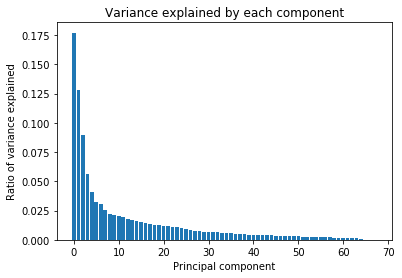

In [246]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(cleanedDataPCA.explained_variance_ratio_)), cleanedDataPCA.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

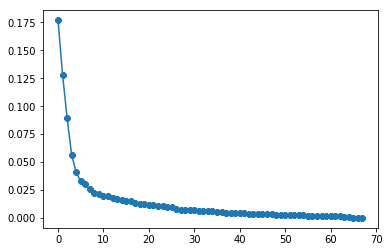

In [247]:
plt.plot(cleanedDataPCA.explained_variance_ratio_, '-8')

In [248]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(66)
cleanedDataPCA_1 = pca.fit(cleanedDataScaled)

In [249]:
#plt.plot(cleanedDataPCA_1.explained_variance_ratio_, '-8')

In [250]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

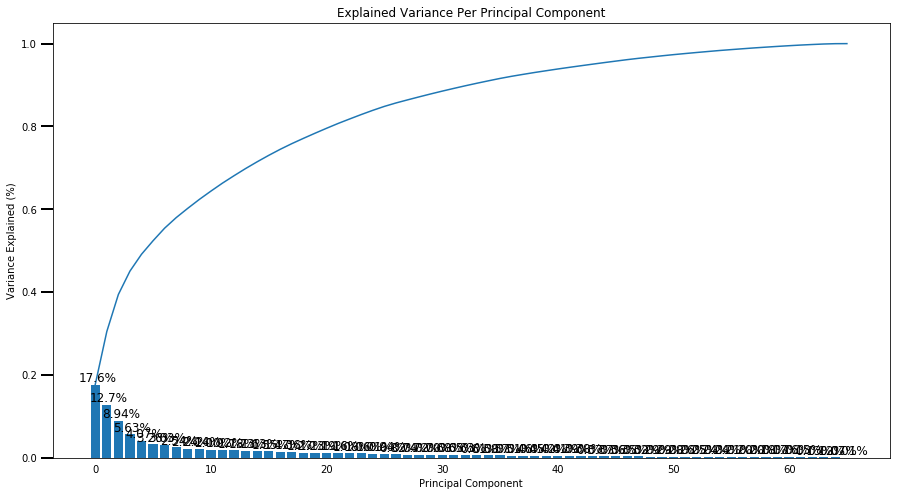

In [251]:
scree_plot(pca)

In [252]:
print(len(pca.explained_variance_ratio_))

66


In [253]:
for i in np.arange(5, 68, 2):
    print('{} variance explained by {} comps.'.format(pca.explained_variance_ratio_[:i].sum(),i))

0.491425125767359 variance explained by 5 comps.
0.5544616241462478 variance explained by 7 comps.
0.602345348957676 variance explained by 9 comps.
0.6438585529709984 variance explained by 11 comps.
0.6810470364524293 variance explained by 13 comps.
0.7146792918444971 variance explained by 15 comps.
0.7449171950755082 variance explained by 17 comps.
0.7712542290212238 variance explained by 19 comps.
0.7955966670061382 variance explained by 21 comps.
0.8180960856213305 variance explained by 23 comps.
0.8389377129257953 variance explained by 25 comps.
0.8567064306398843 variance explained by 27 comps.
0.8713963431204961 variance explained by 29 comps.
0.8852951319439043 variance explained by 31 comps.
0.8982277675934943 variance explained by 33 comps.
0.9102122793388551 variance explained by 35 comps.
0.921101264184943 variance explained by 37 comps.
0.9303461864829865 variance explained by 39 comps.
0.9387695883155527 variance explained by 41 comps.
0.9465960913827631 variance explained

In [254]:
pca30 = PCA(30)
df_30 = pca30.fit(cleanedDataScaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

With PCA, about 50% of the variance can be explained by just 5 components over 90% of the variance can be explained by 35 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [255]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_wt(pca_num, cleanedData):
    df = pd.DataFrame(pca.components_[pca_num])
    df.index = cleanedData.columns
    df.columns = ['PC_{}'.format(pca_num+1)]
    dfSorted = df.sort_index(by = ['PC_{}'.format(pca_num+1)], ascending = False)
    
    return dfSorted

In [256]:
# 1st principal component
pca_wt(0, cleanedData)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


,PC_1
PLZ8_ANTG3,0.222538
PLZ8_ANTG4,0.216077
PLZ8_BAUMAX,0.210859
CAMEO_INTL_2015_LIFESTAGE,0.204780
CAMEO_INTL_2015_WEALTH,0.204780
HH_EINKOMMEN_SCORE,0.198233
ORTSGR_KLS9,0.194332
EWDICHTE,0.192184
FINANZ_HAUSBAUER,0.165829
KBA05_ANTG4,0.152405


In [257]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_wt(1, cleanedData)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


,PC_2
ALTERSKATEGORIE_GROB,0.276223
FINANZ_VORSORGER,0.248546
SEMIO_ERL,0.237516
SEMIO_LUST,0.193174
RETOURTYP_BK_S,0.164691
W_KEIT_KIND_HH,0.114210
SEMIO_KRIT,0.110446
FINANZ_MINIMALIST,0.103694
SEMIO_KAEM,0.100153
FINANZ_HAUSBAUER,0.087219


In [258]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_wt(2, cleanedData)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


,PC_3
SEMIO_VERT,0.346887
SEMIO_SOZ,0.262365
SEMIO_FAM,0.250149
SEMIO_KULT,0.236264
FINANZ_MINIMALIST,0.161936
RETOURTYP_BK_S,0.105695
FINANZ_VORSORGER,0.099715
W_KEIT_KIND_HH,0.085617
ALTERSKATEGORIE_GROB,0.077588
SEMIO_REL,0.070481


In [259]:
pca_wt(0, cleanedData).T

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,CAMEO_INTL_2015_LIFESTAGE,CAMEO_INTL_2015_WEALTH,HH_EINKOMMEN_SCORE,ORTSGR_KLS9,EWDICHTE,FINANZ_HAUSBAUER,KBA05_ANTG4,...,LP_LEBENSPHASE_GROB,LP_LEBENSPHASE_FEIN,INNENSTADT,KONSUMNAEHE,PLZ8_GBZ,FINANZ_MINIMALIST,KBA05_GBZ,KBA05_ANTG1,PLZ8_ANTG1,MOBI_REGIO
PC_1,0.222538,0.216077,0.210859,0.20478,0.20478,0.198233,0.194332,0.192184,0.165829,0.152405,...,-0.130501,-0.144072,-0.160889,-0.165199,-0.165783,-0.19387,-0.210362,-0.215817,-0.222836,-0.23582


In [260]:
pca_wt(1, cleanedData).T

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,SEMIO_ERL,SEMIO_LUST,RETOURTYP_BK_S,W_KEIT_KIND_HH,SEMIO_KRIT,FINANZ_MINIMALIST,SEMIO_KAEM,FINANZ_HAUSBAUER,...,SEMIO_RAT,SEMIO_FAM,FINANZ_ANLEGER,SEMIO_KULT,FINANZ_UNAUFFAELLIGER,SEMIO_TRADV,SEMIO_PFLICHT,FINANZ_SPARER,PRAEGENDE_JUGENDJAHRE_DEC,SEMIO_REL
PC_2,0.276223,0.248546,0.237516,0.193174,0.164691,0.11421,0.110446,0.103694,0.100153,0.087219,...,-0.185345,-0.191129,-0.214173,-0.225284,-0.236239,-0.242929,-0.243401,-0.256752,-0.265154,-0.267717


In [261]:
pca_wt(2, cleanedData).T

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_KULT,FINANZ_MINIMALIST,RETOURTYP_BK_S,FINANZ_VORSORGER,W_KEIT_KIND_HH,ALTERSKATEGORIE_GROB,SEMIO_REL,...,FINANZ_UNAUFFAELLIGER,PRAEGENDE_JUGENDJAHRE_DEC,FINANZ_SPARER,SEMIO_ERL,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,ANREDE_KZ
PC_3,0.346887,0.262365,0.250149,0.236264,0.161936,0.105695,0.099715,0.085617,0.077588,0.070481,...,-0.097382,-0.104655,-0.106365,-0.177738,-0.188037,-0.216472,-0.277749,-0.314254,-0.338675,-0.369231


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

#### First PC:
Features with positive weightages:
PLZ8_ANTG3 :Number of 6-10 family houses in the PLZ8 region (most +ve weight)
PLZ8_ANTG4 : Number of 10+ family houses in the PLZ8 region
PLZ8_BAUMAX :Most common building type within the PLZ8 region
CAMEO_INTL_2015_LIFESTAGE :German CAMEO: Wealth / Life Stage Typology, mapped to international code
CAMEO_INTL_2015_WEALTH: German CAMEO :Wealth / Life Stage Typology, mapped to international code
HH_EINKOMMEN_SCORE :Estimated household net income
ORTSGR_KLS9 :Size of community
EWDICHTE :Density of households per square kilometer
FINANZ_HAUSBAUER :Financial typology, home ownership
KBA05_ANTG :Number of 1-2 family houses in the microcell

Features with negative weightages:
LP_LEBENSPHASE_GROB :Life stage, rough scale (most -ve weight)
LP_LEBENSPHASE_FEIN	:Life stage, fine scale
INNENSTADT :Distance to city center (downtown)
KONSUMNAEHE :Distance from building to point of sale (PoS)
PLZ8_GBZ :Number of buildings within the PLZ8 region
FINANZ_MINIMALIST :Financial typology, low financial interest
KBA05_GBZ :Number of buildings in the microcell
KBA05_ANTG1 :Number of 1-2 family houses in the microcell
PLZ8_ANTG1 :Number of 1-2 family houses in the PLZ8 region
MOBI_REGIO :Movement patterns

PC1 seems to suggests the closer to the city, the wealtheir the family with lower density.

#### PC2
Features with postiive weightages:
ALTERSKATEGORIE_GROB :Estimated age based on given name analysis
FINANZ_VORSORGER :Financial typology, be prepared
SEMIO_ERL :Personality typology, religious
SEMIO_LUST :Personality typology, sensual-minded
RETOURTYP_BK_S :Return type
W_KEIT_KIND_HH :Likelihood of children in household
SEMIO_KRIT :Personality typology, critical-minded
FINANZ_MINIMALIST :Financial typology, low financial interest
SEMIO_KAEM :Personality typology, combative attitude
FINANZ_HAUSBAUER :Financial typology, home ownership

Features with negative weightages:
SEMIO_RAT :Personality typology, rational
SEMIO_FAM :Personality typology, family-minded
FINANZ_ANLEGER :Financial typology, investor
SEMIO_KULT :Personality typology, cultural-minded
FINANZ_UNAUFFAELLIGER :Financial typology, inconspicuous
SEMIO_TRADV	SEMIO_PFLICHT :Personality typology, dutiful
FINANZ_SPARER :Financial typology, money-saver
PRAEGENDE_JUGENDJAHRE_DEC :Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
SEMIO_REL :Personality typology, religious

PC2 seems to suggests the contrast the general lifestyle and mindset of people living in city and sub-urban area.

#### PC3
Features with positive weightages:
SEMIO_VERT :Personality typology, dreamful
SEMIO_SOZ :Personality typology, socially-minded
SEMIO_FAM :Personality typology, family-minded
SEMIO_KULT :Personality typology, cultural-minded
FINANZ_MINIMALIST :Financial typology, low financial interest
RETOURTYP_BK_S :Return type
FINANZ_VORSORGER :Financial typology, be prepared
W_KEIT_KIND_HH :Likelihood of children in household
ALTERSKATEGORIE_GROB :Estimated age based on given name analysis
SEMIO_REL :Personality typology, religious

Features with negative weightages:
FINANZ_UNAUFFAELLIGER :Financial typology, inconspicuous
PRAEGENDE_JUGENDJAHRE_DEC :Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
FINANZ_SPARER :Financial typology, money-saver
SEMIO_ERL :Personality typology, event-oriented
FINANZ_ANLEGER :Financial typology, investor
SEMIO_RAT :Personality typology, rational
SEMIO_KRIT :Personality typology, critical-minded
SEMIO_DOM :Personality typology, dominant-minded
SEMIO_KAEM :Personality typology, combative attitude
ANREDE_KZ :Gender

PC3 also seems to suggests the contrast the general lifestyle and mindset of people living in city and sub-urban area.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [262]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.

scoreList = []
   
def kmeans_score(df, center):
    model = KMeans(n_clusters=center)
    model_fit = model.fit(df)
    preds = model_fit.predict(df)
    score = np.abs(model.score(df))
    scoreList.append(score)
    print(score)
    #return score

In [263]:
#for i in range(10, 31, 2):
#    kmeans_score(cleanedDataScaled, i)

In [264]:
# Storing results from above:
clusters = [i for i in range(10, 31, 2)]
kmeans_scores = [35538056.9614,34460628.2168,33569415.0688,32539155.4471,32365277.4805,31930761.7092,30958360.3067,30629025.2383, 30199973.5118, 29844446.7712, 29499376.3927]

In [265]:
print(kmeans_scores)

[35538056.9614, 34460628.2168, 33569415.0688, 32539155.4471, 32365277.4805, 31930761.7092, 30958360.3067, 30629025.2383, 30199973.5118, 29844446.7712, 29499376.3927]


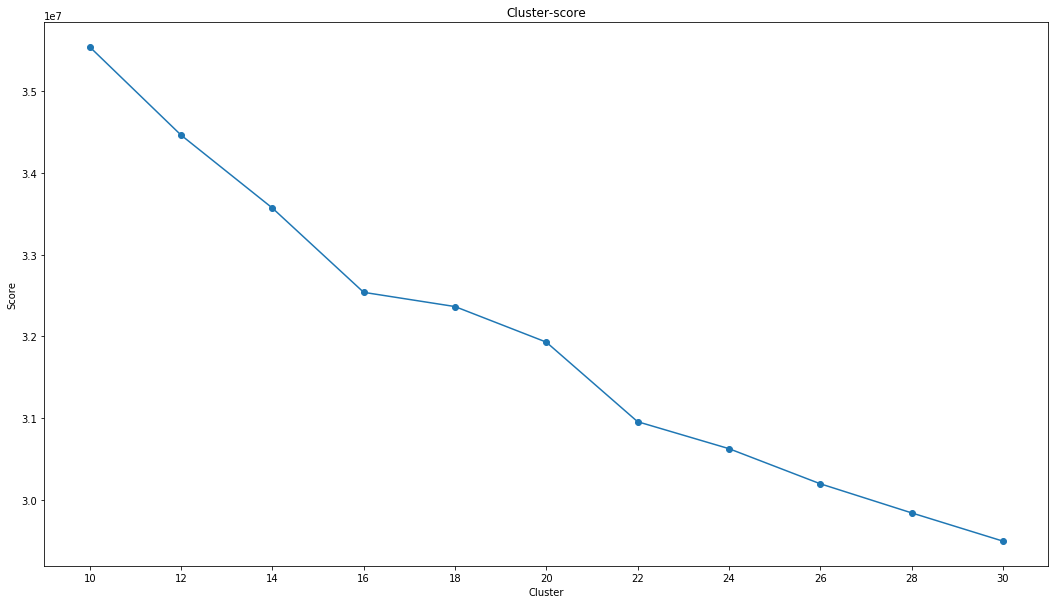

In [266]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(18,10))
plt.title('Cluster-score')
plt.xticks(np.arange(10, 31, 2))
plt.xlabel('Cluster')
plt.ylabel('Score')
plt.plot(clusters, kmeans_scores, linestyle='-', marker='o')

In [267]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_22 = KMeans(n_clusters=22)
clusters_22 = kmeans_22.fit(cleanedDataScaled)

In [268]:
genPred = clusters_22.predict(cleanedDataScaled)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Using the scree plot, it seems that k=22 is the elbow.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [269]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
df_featInfo = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [270]:
#customers.sample(10).T

In [271]:
#customers.info()

In [272]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customersCleaned = clean_data(customers, df_featInfo)

(191652, 85)
(141178, 85)
(141178, 69)
48091     22
149982    31
105485    22
153929    15
187120    14
Name: CAMEO_INTL_2015_WEALTH, dtype: object
1788      14
40554     13
57481     34
12655     24
121900    43
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: object
(141178, 71)


In [273]:
# Replace nans
imp_median = Imputer(missing_values=np.nan, strategy='median', axis=0)
customersCleanedImputed = imp_median.fit_transform(customersCleaned)
custsCleaned = pd.DataFrame(customersCleanedImputed, columns=customersCleaned.columns.tolist())

In [274]:
# Check nans
custsCleaned.isnull().sum().sum()

0

In [275]:
s = StandardScaler()
custsCleanedStd = s.fit_transform(custsCleaned)
custsCleanedScaled = pd.DataFrame(custsCleanedStd, columns=custsCleaned.columns.tolist())

In [276]:
print(custsCleanedScaled.shape)

(141178, 71)


In [277]:
custPCA30 = PCA(71)

In [278]:
custsPCA = custPCA30.fit_transform(custsCleanedScaled)

In [279]:
kmeans_22 = KMeans(n_clusters=22)
clusters_22 = kmeans_22.fit(custsCleanedScaled)

In [280]:
custsPred = clusters_22.predict(custsPCA)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

[]

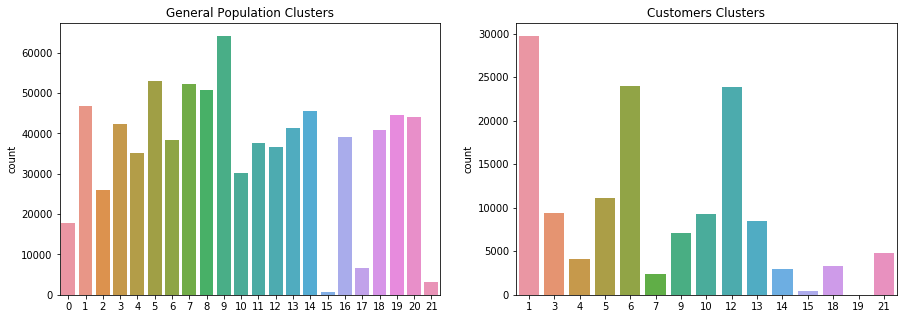

In [281]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title('General Population Clusters')
ax2.set_title('Customers Clusters')
sns.countplot(genPred, ax=ax1)
sns.countplot(custsPred, ax=ax2)
ax1.plot()
ax2.plot()

In [282]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
custCentroid13 = s.inverse_transform(custPCA30.inverse_transform(clusters_22.cluster_centers_[13]))

In [283]:
overRep13 = pd.DataFrame(data=custCentroid13, index=custsCleaned.columns)

In [284]:
print(overRep13.sort_values(by=0, ascending=False))

                                      0
MIN_GEBAEUDEJAHR            1992.741108
GEBURTSJAHR                 1950.590897
KBA13_ANZAHL_PKW             481.510731
CAMEO_INTL_2015_LIFESTAGE     34.261793
CAMEO_INTL_2015_WEALTH        31.151374
LP_LEBENSPHASE_FEIN           22.918132
ALTER_HH                      11.010651
WOHNDAUER_2008                 9.482286
LP_LEBENSPHASE_GROB            7.833003
SEMIO_VERT                     6.535691
SEMIO_LUST                     6.142883
FINANZ_VORSORGER               5.056641
SEMIO_SOZ                      4.947513
W_KEIT_KIND_HH                 4.822556
FINANZ_MINIMALIST              4.765162
SEMIO_KULT                     4.409928
ORTSGR_KLS9                    4.311657
SEMIO_REL                      4.298317
SEMIO_KAEM                     4.272626
GEBAEUDETYP_RASTER             4.200783
PLZ8_HHZ                       4.154978
SEMIO_ERL                      4.151936
ANZ_HAUSHALTE_AKTIV            4.143108
MOBI_REGIO                     4.116549


In [285]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
custCentroid3 = s.inverse_transform(custPCA30.inverse_transform(clusters_22.cluster_centers_[3]))
custCentroid9 = s.inverse_transform(custPCA30.inverse_transform(clusters_22.cluster_centers_[9]))
custCentroid10 = s.inverse_transform(custPCA30.inverse_transform(clusters_22.cluster_centers_[10]))

In [286]:
# Centroid 3
underRep3 = pd.DataFrame(data=custCentroid3, index=custsCleaned.columns)
print(underRep3.sort_values(by=0, ascending=False))

                                      0
MIN_GEBAEUDEJAHR            1992.838794
GEBURTSJAHR                 1951.749760
KBA13_ANZAHL_PKW             483.438714
CAMEO_INTL_2015_LIFESTAGE     44.199086
CAMEO_INTL_2015_WEALTH        34.832000
LP_LEBENSPHASE_FEIN           23.977966
ALTER_HH                      15.332229
LP_LEBENSPHASE_GROB            9.770953
WOHNDAUER_2008                 6.906857
SEMIO_ERL                      6.618598
SEMIO_LUST                     5.907704
SEMIO_VERT                     5.879838
BALLRAUM                       5.502185
SEMIO_MAT                      5.377238
INNENSTADT                     5.101127
ORTSGR_KLS9                    5.076963
SEMIO_KULT                     4.910353
SEMIO_DOM                      4.883796
REGIOTYP                       4.879858
SEMIO_FAM                      4.655349
SEMIO_SOZ                      4.612199
HH_EINKOMMEN_SCORE             4.504407
SEMIO_RAT                      4.303855
MOBI_REGIO                     4.203744


In [287]:
# Centroid 9
underRep9 = pd.DataFrame(data=custCentroid9, index=custsCleaned.columns)
print(underRep9.sort_values(by=0, ascending=False))

                                      0
MIN_GEBAEUDEJAHR            1992.252392
GEBURTSJAHR                 1951.941459
KBA13_ANZAHL_PKW             707.965916
CAMEO_INTL_2015_WEALTH        38.551391
LP_LEBENSPHASE_FEIN           35.842065
CAMEO_INTL_2015_LIFESTAGE     23.595572
ALTER_HH                      15.156518
LP_LEBENSPHASE_GROB            6.968928
WOHNDAUER_2008                 6.919985
SEMIO_ERL                      6.796866
INNENSTADT                     6.702204
BALLRAUM                       5.985024
ORTSGR_KLS9                    5.695379
SEMIO_LUST                     5.513990
SEMIO_KRIT                     5.486887
SEMIO_VERT                     4.968734
SEMIO_MAT                      4.665530
SEMIO_RAT                      4.587569
KBA05_GBZ                      4.574931
W_KEIT_KIND_HH                 4.564012
REGIOTYP                       4.375957
SEMIO_DOM                      4.239455
FINANZ_MINIMALIST              4.025055
SEMIO_SOZ                      4.000387


In [288]:
# Centroid 10
underRep10 = pd.DataFrame(data=custCentroid10, index=custsCleaned.columns)
print(underRep10.sort_values(by=0, ascending=False))

                                      0
MIN_GEBAEUDEJAHR            1994.639654
GEBURTSJAHR                 1957.133281
KBA13_ANZAHL_PKW            1034.652759
CAMEO_INTL_2015_LIFESTAGE     27.120415
CAMEO_INTL_2015_WEALTH        22.971998
ANZ_HAUSHALTE_AKTIV           22.284100
LP_LEBENSPHASE_FEIN           19.867151
ALTER_HH                      14.246925
WOHNDAUER_2008                 6.968079
LP_LEBENSPHASE_GROB            6.654879
SEMIO_ERL                      5.617590
ORTSGR_KLS9                    5.480327
SEMIO_LUST                     5.412406
SEMIO_KAEM                     5.358951
INNENSTADT                     5.272918
PLZ8_HHZ                       5.251058
PLZ8_GBZ                       5.087733
BALLRAUM                       5.003187
SEMIO_DOM                      4.853659
FINANZ_VORSORGER               4.450247
SEMIO_MAT                      4.413816
SEMIO_VERT                     4.384280
MOBI_REGIO                     4.328012
W_KEIT_KIND_HH                 4.216443


### Discussion 3.3: Compare Customer Data to Demographics Data

From results above, cluster 13 is overrepresented in the customer data as compared to the general population data.
This group seems to be wealthy, financially prudent and culturally minded that is popular with the company 

Cluster 3, 9 and 10 are underrepresented in the customer data as compared to the general population data.
This group seems to be a younger population which is combative; socially minded; religious; materialistic; critical minded that is not captured by the company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.